# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays

# Use filtered df with pocket n°435

In [19]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_filtered_435.csv")
print(df_days.head())


         date  nb_cars  nb_cars_cxl  nb_bookings  nb_bookings_cxl
0  2021-06-01       29            2            7                0
1  2021-06-02       26            2           13                0
2  2021-06-03       30            2           10                1
3  2021-06-04       25            0           45                2
4  2021-06-05       64            2           10                1


In [20]:
# Convert 'date' column to datetime data type
df_days['date'] = pd.to_datetime(df_days['date'])

# Reshape the DataFrame using melt
df_melted = df_days.melt(id_vars='date', value_vars=['nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'])

# Create the line plot
fig = go.Figure()

# Add traces for each variable
for variable in ['nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl']:
    fig.add_trace(go.Scatter(
        x=df_melted['date'],
        y=df_melted[df_melted['variable'] == variable]['value'],
        name=variable
    ))

# Add range slider and selectors
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    title="Number of cars and bookings per day"
)

# Set the height of the plot
fig.update_layout(height=800)

# Show the graph
fig.show()


# Prophet nb of cars

## Just the nb of cars as y

In [24]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()


,ds,y
0,2021-06-01,29
1,2021-06-02,26
2,2021-06-03,30
3,2021-06-04,25
4,2021-06-05,64


In [22]:
# Define the split percentages
train_percentage = 0.95
test_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)

# Split the data into train and test sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print()

# Define and fit the Prophet model
model = Prophet()
model.fit(train_set)

# Create future dates for the test period
future_test = model.make_future_dataframe(periods=7)

# Predict on the test set
forecast_test = model.predict(future_test)

# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)


11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing


train_rows: 712
test_rows: 37

RMSE for the test set: 40.5579514033521
MAPE for the test set: 33.71717535648957


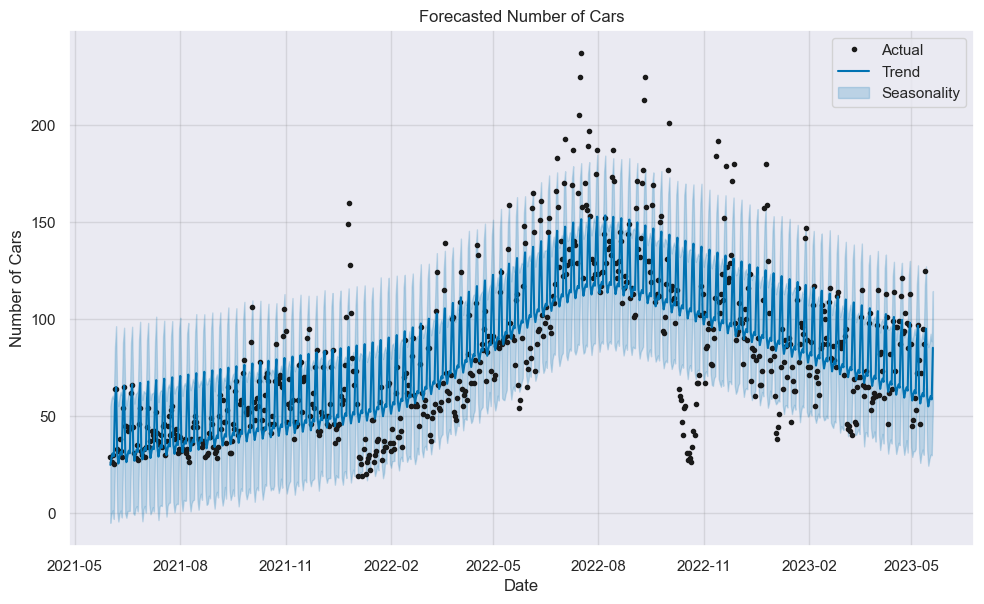

In [23]:
# Plot the graph
fig1 = model.plot(forecast_test)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

# Add legend
plt.legend(['Actual', 'Trend', 'Seasonality', 'Forecast'])

plt.show()

## Forecast nb of cars with french holidays (from holidays package)

In [9]:
# Define the split percentages
train_percentage = 0.95
test_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)

# Split the data into train and test sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print()

# Add the 'holiday' column
fr_holidays = holidays.France()
train_set['holiday'] = train_set['ds'].apply(lambda x: 'Holiday' if x in fr_holidays else '')
test_set['holiday'] = test_set['ds'].apply(lambda x: 'Holiday' if x in fr_holidays else '')

# Define and fit the Prophet model
model = Prophet(holidays=train_set[train_set['holiday'] != ''])
model.fit(train_set)

# Create future dates for the test period
future_test = model.make_future_dataframe(periods=7)

# Add the 'holiday' column for future dates
future_test['holiday'] = future_test['ds'].apply(lambda x: 'Holiday' if x in fr_holidays else '')

# Predict on the test set
forecast_test = model.predict(future_test)

# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

# Predict on the test set
forecast_test = model.predict(future_test)

/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_34748/697644739.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_34748/697644739.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

train_rows: 712
test_rows: 37



In [10]:
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

RMSE for the test set: 40.60331635642236
MAPE for the test set: 33.321163706215856


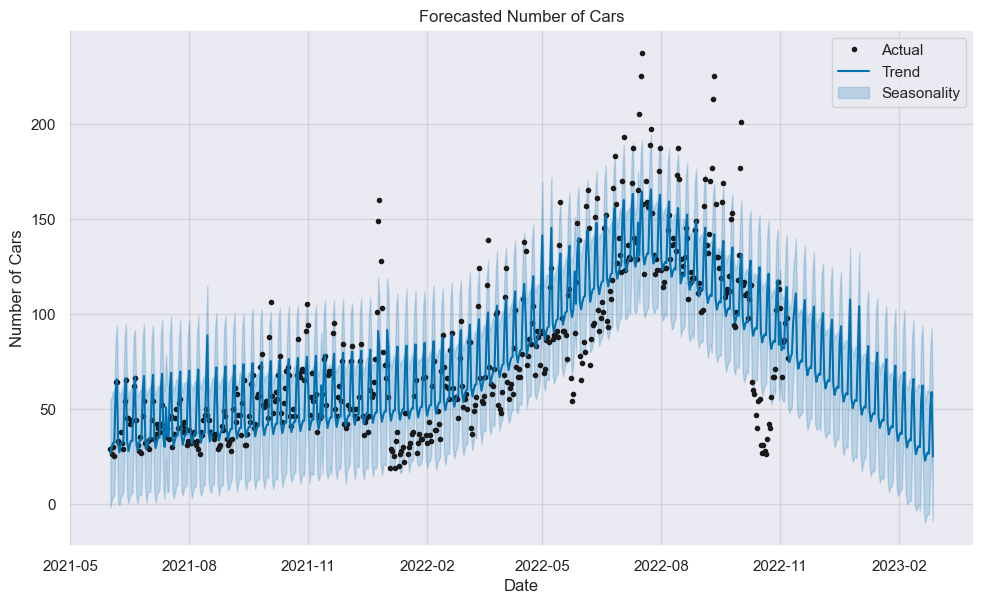

In [26]:
# Plot the graph
fig1 = model.plot(forecast_test)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

# Add legend
plt.legend(['Actual', 'Trend', 'Seasonality', 'Forecast'])

plt.show()

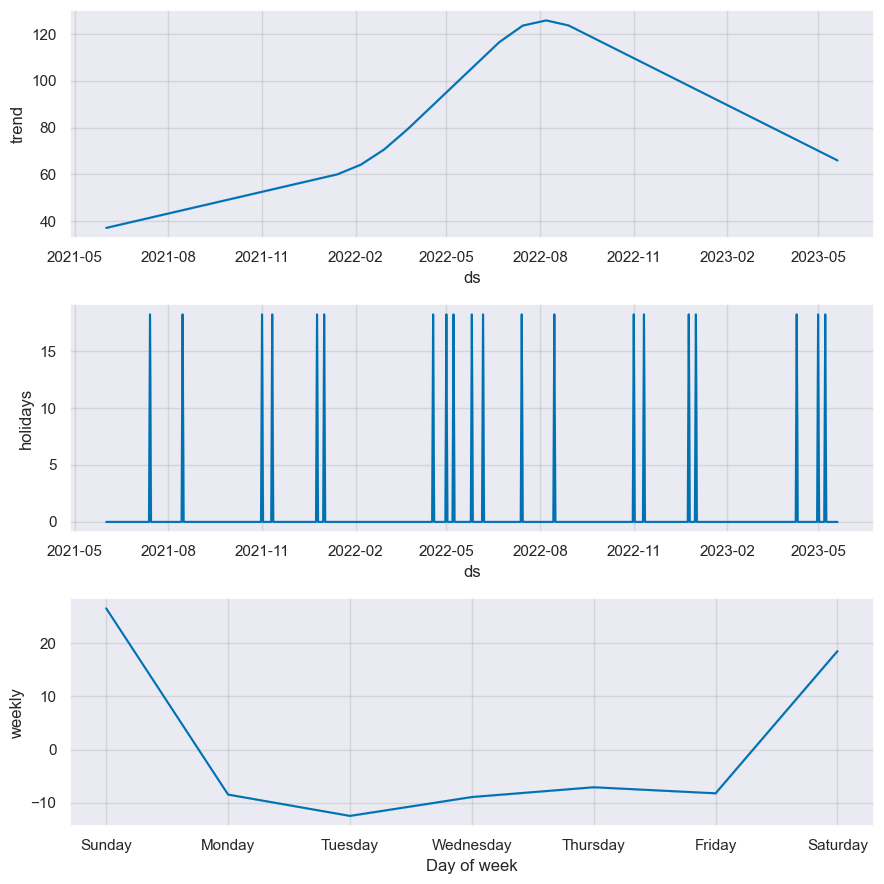

In [12]:
# Plot the components
fig2 = model.plot_components(forecast_test)
